**References for time-series forecasting method**
* https://medium.com/analytics-vidhya/holt-winters-forecasting-13c2e60d983f
* https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873
* https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
* https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
* https://stackoverflow.com/questions/50785479/holt-winters-time-series-forecasting-with-statsmodels
* http://ethen8181.github.io/machine-learning/time_series/1_exponential_smoothing.html#Triple-Exponential-Smoothing---Holt-Winters-Method
* https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html#LOESS-degree
* https://stackoverflow.com/questions/51048895/seasonal-trend-loess-method-for-time-series-in-python
* https://otexts.com/fpp2/stl.html
* https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

In [2]:
#import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from sklearn.metrics import mean_absolute_error,mean_squared_error
from datetime import datetime as dt

#import maya

# **1. Overview of Data**

## 50k CAG Sales Data

In [ ]:
#read data from csv file
sales_time_series = pd.read_csv('sales_50k_CAG.csv',parse_dates=['time'])
print(sales_time_series)

In [ ]:
# see dataframe information
sales_time_series.info()

In [ ]:
#converting time column into datetime format
sales_time_series['time'] = pd.to_datetime(sales_time_series['time'])
sales_time_series.info()

In [ ]:
sales_time_series

## 2.4 CAG Sales

In [13]:
#read data from csv file
sales_19_22 = pd.read_csv('2.4 CAG sales.csv',parse_dates=['date'])
sales_19_22.set_index('date', inplace = True)
#sales_19_22.drop(sales_19_22.iloc[:, 2:15], inplace=True, axis=1)
sales_19_22

,2.4 CAG sales
date,
2019-01-01,14474
2019-02-01,15850
2019-03-01,15417
2019-04-01,13572
2019-05-01,19084
2019-06-01,15839
2019-07-01,16046
2019-08-01,14526
2019-09-01,14944


In [14]:
# see dataframe information
sales_19_22.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2019-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   2.4 CAG sales  49 non-null     int64
dtypes: int64(1)
memory usage: 784.0 bytes


# **2. Visualization of Data**

## 50k CAG Sales

In [ ]:
# Total Sales - there's a slight trend of sales going up toward end of 2022
sales_time_series.plot(x='time',y='total_sales',kind='line',color='red',title='Total Sales')
# Additive trend - going up in linear line
# Multiplicative seasonality - the magnitude of the trend is increasing and descreasing differently throughout time series


### Total Sales
* Additive trend - going up in linear line
* Multiplicative seasonality - the magnitude of the trend is increasing and descreasing differently throughout time series

In [ ]:

# sales over 50k- there's a slight trend of sales going up toward end of 2022
sales_time_series.plot(x='time',y='sales_over 50k CAG',kind='line',color='blue',title='Sales of projects over $50k')

### Sales of projects over 50k 
* Trend - additive going up in linear trend
* Multiplicative seasonality - the magnitude of the trend is increasing and descreasing differently throughout time series

In [ ]:
# sales under 50k- there's a slight trend of sales going up toward end of 2022
sales_time_series.plot(x='time',y='sales_under 50k CAG',kind='line',color='purple',title='Sales of projects under $50k')

### Sales of projects under 50k 
* trending upward for the majority, but sudden drop in January and seem to change in magnitude over the time period --> multiplicative?
* Multiplicative seasonality - the magnitude of the trend is increasing and descreasing differently throughout time series

## 2.4 CAG Sales

In [16]:
sales_19_22.plot(x= 'date',y='2.4 CAG sales',kind = 'line', color= 'pink',title='Sales of 2.4 CAG category from 2019-2022')

KeyError: 'date'

* downward trend 2019-2021 but trending upward slightly in 2022
* seasonality seem not consistent

# **2.1 Creating subset of the dataset**
* in order to fit the model using Holt-Winters method, the data needs to be grouped and formatted so as the indexes are the time periods
* by creating subset, we're seperating sales into three categories: total of the sales, sales of projects under 50k and over 50k. As indicated above, the trends and patterns of the sales in this three categories seem to be a bit different. Hopefully seperating them will let us examine if the Holt-Winter method is more applicable to a certain type of sales.

In [ ]:
#creating a subset of just total sales
total_sales = sales_time_series[['time','total_sales']].copy()
total_sales['time'] = pd.to_datetime(total_sales['time']) #converting time to datetime
total_sales.set_index('time', inplace = True) #setting time as index


In [ ]:
#creating a subset of just sales of projects over 50k
sales_over_50k = sales_time_series[['time','sales_over 50k CAG']].copy()
sales_over_50k['time'] = pd.to_datetime(sales_over_50k['time']) #converting time to datetime
sales_over_50k.set_index('time', inplace = True) #setting time as index

In [ ]:
#creating a subset of just sales of projects under 50k
sales_under_50k = sales_time_series[['time','sales_under 50k CAG']].copy()
sales_under_50k['time'] = pd.to_datetime(sales_under_50k['time']) #converting time to datetime
sales_under_50k.set_index('time', inplace = True) #setting time as index

# **2.2 Trend and Seasonality Decomposition**

## 50k CAG Sales

In [ ]:
# find trend line and seasonality using statsmodels module -- Total Sales
decompose_result = seasonal_decompose(total_sales.dropna(), model='multiplicative ', period=1)
decompose_result.plot()
plt.show()

In [ ]:
#Trend-seasonality decomposition - Loess method
decompose_resulta = STL(total_sales,period =12)
res = decompose_resulta.fit()
fig = res.plot()

In [ ]:
# find trend line and seasonality using statsmodels module -- Over 50k
decompose_result1= seasonal_decompose(sales_over_50k.dropna(), model='multiplicative ', period=1)
decompose_result1.plot()
plt.show()

In [ ]:
#Trend-seasonality decomposition - Loess method
decompose_result1a = STL(sales_over_50k,period =12)
res = decompose_result1a.fit()
fig = res.plot()

In [ ]:
# find trend line and seasonality using statsmodels module -- Under 50k
decompose_result2= seasonal_decompose(sales_under_50k, model='multiplicative', period=1)
decompose_result2.plot()
plt.show()

In [ ]:
#Trend-seasonality decomposition - Loess method
decompose_result2a = STL(sales_under_50k,period =12)
res = decompose_result2a.fit()
fig = res.plot()

*All three types of sales seem to have upward trends but no seasonality.*

In [ ]:
# sales_time_series=sales_time_series.groupby('time').sum()
# sales_time_series

In [ ]:
# Resampling is necessary when you’re given a data set recorded in some time interval and you want to change the time interval to something else. 
# For example, you could aggregate monthly data into yearly data, or you could upsample hourly data into minute-by-minute data.
#pd.DataFrame.resample
#(
# rule, 
# how=None, 
# axis=0, 
# fill_method=None, 
# closed=None, 
# label=None, 
# convention=”start”, 
# kind=None, 
# loffset=None, 
# limit=None, 
# base=0, 
# on=None, 
# level=None
# )


## 2.4 CAG Sales

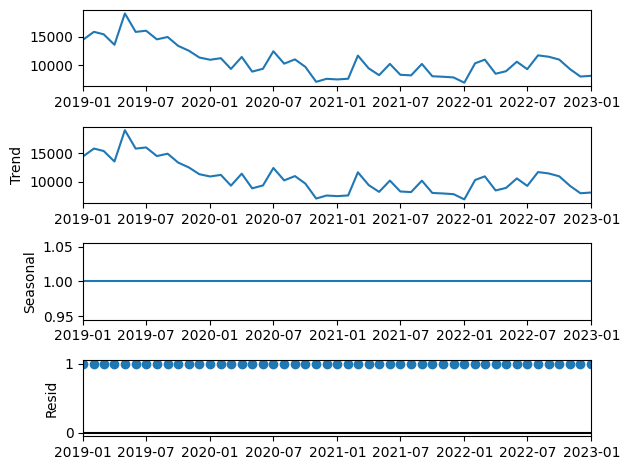

In [17]:
# find trend line and seasonality using statsmodels module -- Under 50k
decompose_result4= seasonal_decompose(sales_19_22, model='multiplicative', period=1)
decompose_result4.plot()
plt.show()

* Seasonal-Trend decomposition using LOESS (STL) - Loess is a method for estimating nonlinear relationships
*to read more about STL* https://otexts.com/fpp2/stl.html
* https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html
* *uses locally fitted regression models to decompose a time series into trend, seasonal, and remainder components.*

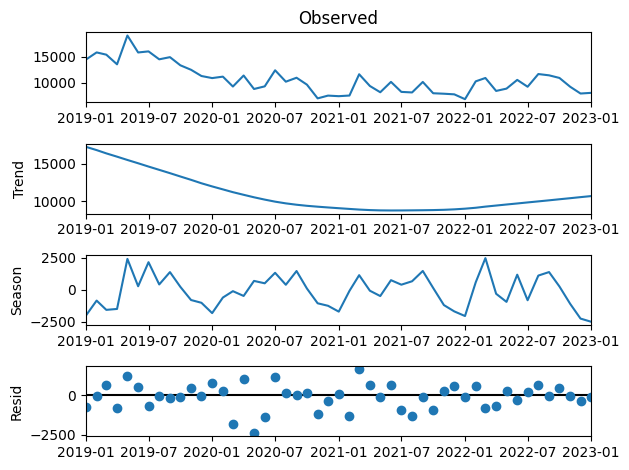

In [18]:
decompose_result4a = STL(sales_19_22,period =12)
res = decompose_result4a.fit()
fig = res.plot()

* There is a trend of going downward and slow pick up toward 2022
* Seasonality: drops in January, boosts around June-Aug, declines toward end-of-year (around Nov-Dec)

# **3. Split Data into Train and Test**

In [51]:
# Train/Test Split
train1= total_sales[:18] #total sales until June 2022
train2 = sales_over_50k[:18] #sales over 50k until June 2022
train3 = sales_under_50k[:18] #sales under 50k until June 2022
train4 = sales_19_22[:41] #2.4 CAG sales from 2019-2022 May
train5 = sales_19_22[15:41] # 2.4 CAG sales ONLY AFTER COVID 

test1 = total_sales[18:] #total sales after June 2022
test2 = sales_over_50k[18:] #sales over 50k after June 2022
test3 = sales_under_50k[18:] #sales under 50k after June 2022
test4 = sales_19_22[41:] #2.4 CAG sales 2022 June-Dec 

NameError: name 'total_sales' is not defined

In [52]:
train5 = sales_19_22[15:41] # 2.4 CAG sales ONLY AFTER COVID 
test4 = sales_19_22[41:] #2.4 CAG sales 2022 June- 2023 Jan

In [53]:
train5

,2.4 CAG sales
date,
2020-04-01,11430
2020-05-01,8850
2020-06-01,9354
2020-07-01,12431
2020-08-01,10249
2020-09-01,11004
2020-10-01,9682
2020-11-01,7053
2020-12-01,7585


In [54]:
test4

,2.4 CAG sales
date,
2022-06-01,10591
2022-07-01,9280
2022-08-01,11711
2022-09-01,11465
2022-10-01,10966
2022-11-01,9282
2022-12-01,7983
2023-01-01,8113


# **4.1 Fitting the Model - Single/Simple Exponential Smoothing**
* this method is most applicable when the data does not show any trend or seasonality 

## 50k CAG SALES

In [ ]:
## Single Exponential Smoothing Method - data with no trend and seasonality
total_sales.index.freq = 'MS' # Set the frequency of the date time index as Monthly start as indicated by the data
# Set the value of Alpha and define m (Time Period) -- smoothing coefficient
m = 12
alpha = 1/(2*m)

In [ ]:
train1['HWES1'] = SimpleExpSmoothing(train1['total_sales']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
train1[['total_sales','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');

* smoothing curve does not fit very well because this method does not work well with data that has trends and seasonality.

# 2.4 CAG SALES

### Data 2019-2022

In [24]:
## Single Exponential Smoothing Method - data with no trend and seasonality
sales_19_22.index.freq = 'MS' # Set the frequency of the date time index as Monthly start as indicated by the data
# Set the value of Alpha and define m (Time Period) -- smoothing coefficient
m = 12
alpha = 1/(2*m)

In [ ]:
train4['HWES1'] = SimpleExpSmoothing(train4['2.4 CAG sales']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
train4[['2.4 CAG sales','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');

* Single smoothing is off because the sales started out strong prior to Covid and is offsetting the rest of the sales periods afterward

### Data from 2020-2022 (AFTER COVID)

C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\3897067019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train5['HWES1'] = SimpleExpSmoothing(train5['2.4 CAG sales']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues


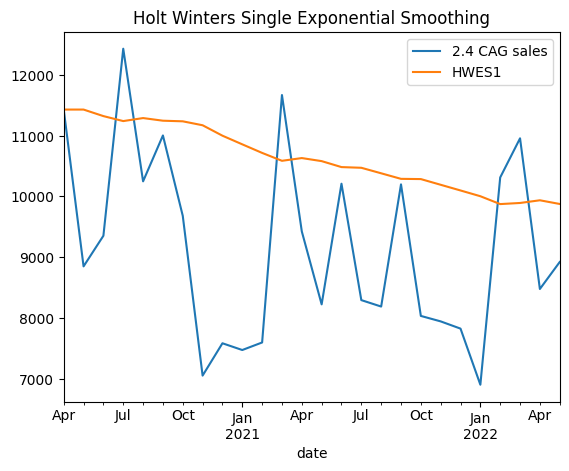

In [55]:
train5['HWES1'] = SimpleExpSmoothing(train5['2.4 CAG sales']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
train5[['2.4 CAG sales','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');

* This is not the best method, but single smoothing fits better if not considering the sales performance prior to Covid -- sales were much higher prior to Covid --> outweighting the later sales periods

# **4.2 Fitting the Model - Double Exponential Smoothing**
* this method is most applicable when the data has trends and/or seasonality 

## 50 CAG SALES

In [ ]:
## Double Exponential Smoothing Method - good for data with trend 
train1['HWES2_ADD'] = ExponentialSmoothing(train1['total_sales'],trend='add').fit().fittedvalues #additive Trend
train1['HWES2_MUL'] = ExponentialSmoothing(train1['total_sales'],trend='mul').fit().fittedvalues #multiplicative Trend
train1[['total_sales','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');

In [ ]:
# total_sales['HWES2_ADD'] = ExponentialSmoothing(total_sales['total_sales'],trend='add').fit().fittedvalues #additive Trend
# total_sales[['total_sales','HWES2_ADD']].plot(title='Holt Winters Double Exponential Smoothing: Additive Trend');

* Exponential smoothing does not seem to fit well with the data pattern - not capturing the variance of sales in each month very well, only capturing upward trend slightly.
* Trying different scenarios when trend is additive vs trend is multiplicative, but the graph is showing the same results?


In [ ]:
train1

## 2.4 CAG SALES

### Data from 2019-2022

C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\3355718738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train4['HWES2_ADD'] = ExponentialSmoothing(train4['2.4 CAG sales'],trend='add').fit().fittedvalues #additive Trend
c:\Users\670275809\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\3355718738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

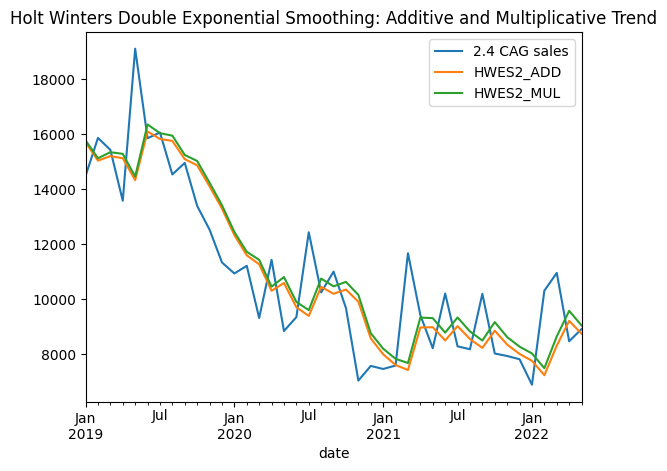

In [56]:
## Double Exponential Smoothing Method - good for data with trend 
train4['HWES2_ADD'] = ExponentialSmoothing(train4['2.4 CAG sales'],trend='add').fit().fittedvalues #additive Trend
train4['HWES2_MUL'] = ExponentialSmoothing(train4['2.4 CAG sales'],trend='mul').fit().fittedvalues #multiplicative Trend
train4[['2.4 CAG sales','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');

* Additive trends and multiplicative seasonality probably fit the sales patterns better

### Data from 2020-2022 (AFTER COVID)

C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\896532806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train5['HWES2_ADD'] = ExponentialSmoothing(train5['2.4 CAG sales'],trend='add').fit().fittedvalues #additive Trend
c:\Users\670275809\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\896532806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

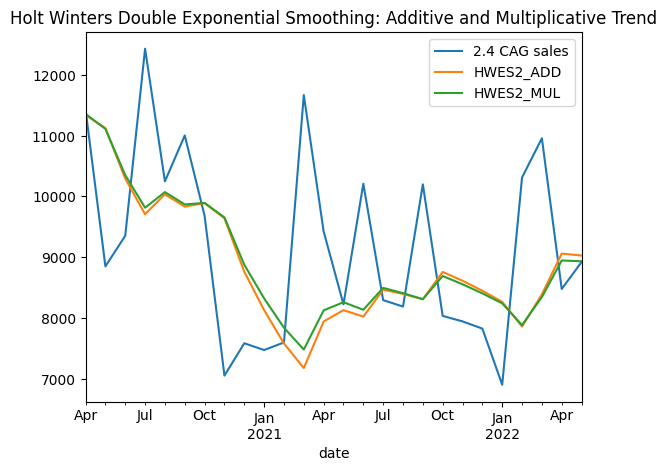

In [57]:
## Double Exponential Smoothing Method - good for data with trend 
train5['HWES2_ADD'] = ExponentialSmoothing(train5['2.4 CAG sales'],trend='add').fit().fittedvalues #additive Trend
train5['HWES2_MUL'] = ExponentialSmoothing(train5['2.4 CAG sales'],trend='mul').fit().fittedvalues #multiplicative Trend
train5[['2.4 CAG sales','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');

# **4.3 Triple Exponential Smoothing**
*  good for data with both trend and seasonality

## 50k CAG Sales

In [ ]:
## Triple Exponential Smoothing Method - good for data with both trend and seasonality
train1['HWES3_ADD'] = ExponentialSmoothing(train1['total_sales'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
train1['HWES3_MUL'] = ExponentialSmoothing(train1['total_sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
train1[['total_sales','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');

*ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.* 
* Cannot compute right now because we don't have enough data for two full cycles to account for seasionality

## 2.4 CAG Sales

### Data from 2019-2022

c:\Users\670275809\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\2530640541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train4['HWES3_ADD'] = ExponentialSmoothing(train4['2.4 CAG sales'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
c:\Users\670275809\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\2530640541.py:3: SettingWithCopyWar

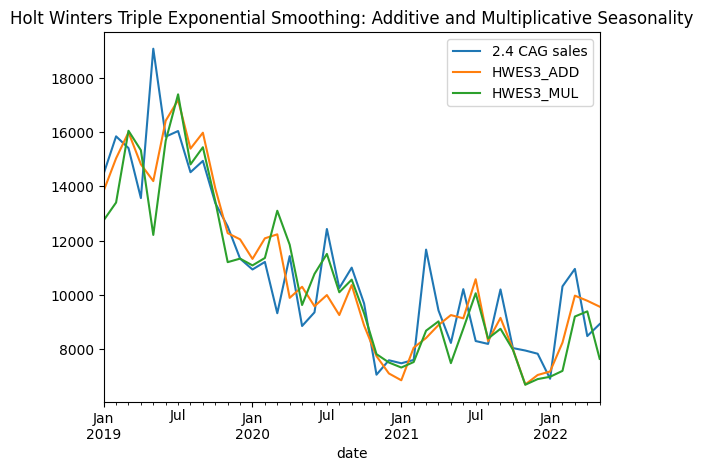

In [47]:
## Triple Exponential Smoothing Method - good for data with both trend and seasonality
train4['HWES3_ADD'] = ExponentialSmoothing(train4['2.4 CAG sales'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
train4['HWES3_MUL'] = ExponentialSmoothing(train4['2.4 CAG sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
train4[['2.4 CAG sales','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');

In [48]:
train4

,2.4 CAG sales,HWES3_ADD,HWES3_MUL
date,,,
2019-01-01,14474,13839.422787,12751.250014
2019-02-01,15850,15039.007924,13407.246313
2019-03-01,15417,15998.078975,16056.117721
2019-04-01,13572,14818.303052,15337.428355
2019-05-01,19084,14198.638353,12211.688654
2019-06-01,15839,16426.143099,15686.191897
2019-07-01,16046,17190.326797,17400.793054
2019-08-01,14526,15396.885498,14815.131872
2019-09-01,14944,15984.601411,15447.715890


### Data from 2020-2022

C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\2060441792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train5['HWES3_ADD'] = ExponentialSmoothing(train5['2.4 CAG sales'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
c:\Users\670275809\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\670275809\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\670275809\AppData\Local\Temp\ipykernel_19224\2060441792.py:3: SettingWithCopyWarning: 
A value is tryi

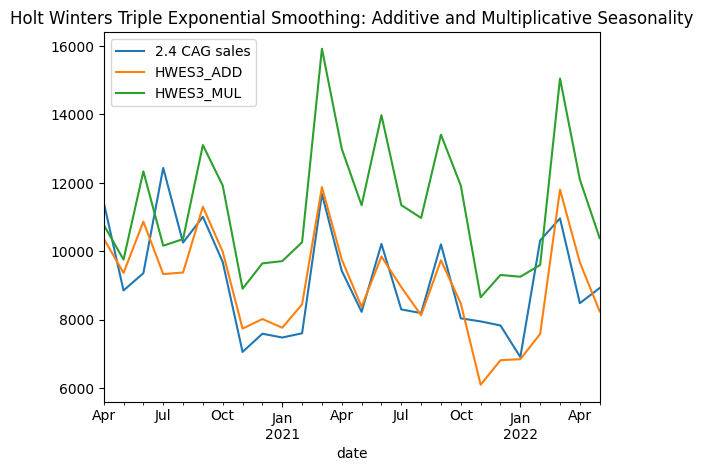

In [58]:
## Triple Exponential Smoothing Method - good for data with both trend and seasonality
train5['HWES3_ADD'] = ExponentialSmoothing(train5['2.4 CAG sales'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
train5['HWES3_MUL'] = ExponentialSmoothing(train5['2.4 CAG sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
train5[['2.4 CAG sales','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');

In [59]:
train5

,2.4 CAG sales,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
date,,,,,,
2020-04-01,11430,11430.000000,11340.428182,11358.289747,10368.460303,10768.967065
2020-05-01,8850,11430.000000,11124.141102,11112.551416,9362.052985,9751.744641
2020-06-01,9354,11322.500000,10294.629044,10351.314935,10861.174848,12332.804286
2020-07-01,12431,11240.479167,9708.314956,9815.066744,9328.538810,10157.938310
2020-08-01,10249,11290.084201,10035.331400,10072.320600,9374.487491,10351.091595
2020-09-01,11004,11246.705693,9832.855201,9869.074083,11295.725799,13099.424733
2020-10-01,9682,11236.592956,9890.330809,9894.184751,9980.538871,11915.246655
2020-11-01,7053,11171.818249,9641.631042,9655.313380,7735.959032,8900.148504
2020-12-01,7585,11000.200822,8761.607064,8877.298541,8014.380254,9640.947792


* Triple smoothing method seems to exaggerate the trends and seasonality 
* Double smoothing method with multiplicative trends and seasonality seem to provide the best smoothed values and fit the actual sales the best

# **5. Fitting the model on testing set - Double Exponential method**

## 50k CAG Sales

In [ ]:
## Fit the model on trainning data
train1.index.freq = 'MS' # Set the frequency of the date time index as Monthly start as indicated by the data - total sales
train2.index.freq = 'MS' # Set the frequency of the date time index as Monthly start as indicated by the data - sales over 50k
train3.index.freq = 'MS' # Set the frequency of the date time index as Monthly start as indicated by the data - sales under 50k
# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1/(2*m)

In [ ]:
alpha

In [ ]:
# Total Sales
fitted_model = ExponentialSmoothing(train1['total_sales'],trend='mul').fit()
test_predictions = fitted_model.forecast(5)
train1['total_sales'].plot(legend=True,label='TRAIN')
test1['total_sales'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [ ]:
# For sales over 50k CAG
fitted_model2 = ExponentialSmoothing(train2['sales_over 50k CAG'],trend='add').fit()
test_predictions2 = fitted_model2.forecast(5)
train2['sales_over 50k CAG'].plot(legend=True,label='TRAIN')
test2['sales_over 50k CAG'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions2.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [ ]:
fitted_model2.forecast(5)

In [ ]:
train2

In [ ]:
# For sales under 50k CAG
fitted_model3 = ExponentialSmoothing(train3['sales_under 50k CAG'],trend='add').fit()
test_predictions3 = fitted_model3.forecast(5)
train3['sales_under 50k CAG'].plot(legend=True,label='TRAIN')
test3['sales_under 50k CAG'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions3.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

## Model Performance Evaluation

In [ ]:
# under_50k_predictions = pd.DataFrame(data=test_predictions3)
# under_50k_predictions

In [ ]:
# over_50k_predictions = pd.DataFrame(data=test_predictions2)
# over_50k_predictions

In [ ]:
# sales_predictions = pd.DataFrame(data=test_predictions)
# sales_predictions

In [ ]:
total_sales

In [ ]:
# Evaluation Metric - Total Sales
print(f'Mean Absolute Error = {mean_absolute_error(test1,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test1,test_predictions)}')

In [ ]:
# Evaluation Metric - Sales over 50k
print(f'Mean Absolute Error = {mean_absolute_error(test2,test_predictions2)}')
print(f'Mean Squared Error = {mean_squared_error(test2,test_predictions2)}')

In [ ]:
# Evaluation Metric - Sales under 50k
print(f'Mean Absolute Error = {mean_absolute_error(test3,test_predictions3)}')
print(f'Mean Squared Error = {mean_squared_error(test3,test_predictions3)}')

In [ ]:
test_predictions = pd.DataFrame(data=test_predictions, columns= ['predicted'])
total_sales_preds = pd.concat([test_predictions,test1],axis=1)
total_sales_preds

## 2.4 CAG SALES
* Data from 2020-2022

In [60]:
## Fit the model on trainning data
train5.index.freq = 'MS' # Set the frequency of the date time index as Monthly start as indicated by the data - 2.4 CAG Sales 2020-22
# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1/(2*m)

Text(0.5, 1.0, 'Train, Test and Predicted Test using Double Smoothing')

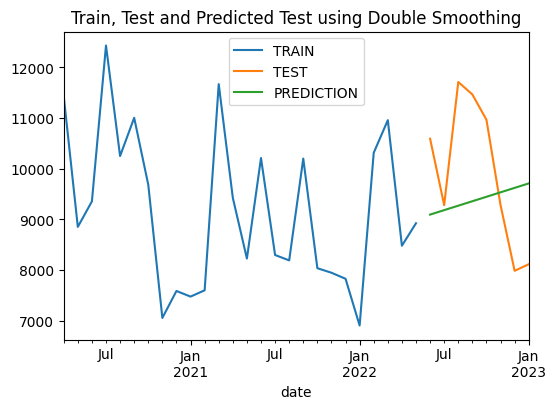

In [75]:
fitted_model5 = ExponentialSmoothing(train5['2.4 CAG sales'],trend='add').fit()
test_predictions5 = fitted_model5.predict(start=test4.index[0], end=test4.index[-1])
train5['2.4 CAG sales'].plot(legend=True,label='TRAIN')
test4['2.4 CAG sales'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions5.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Double Smoothing')

In [69]:
test_predictions5= pd.DataFrame(data=test_predictions5)
test_predictions5

,0
2022-06-01,9009.591188
2022-07-01,9088.256682
2022-08-01,9167.609028
2022-09-01,9247.654223
2022-10-01,9328.398318
2022-11-01,9409.847414
2022-12-01,9492.007667
2023-01-01,9574.885286


In [74]:
# Evaluation Metric - 2.4 CAG data 2019-22
print(f'Mean Absolute Error = {mean_absolute_error(test4,test_predictions5)}')
print(f'Mean Squared Error = {mean_squared_error(test4,test_predictions5)}')

Mean Absolute Error = 1393.9516396268855
Mean Squared Error = 2533065.6673769215


# **5.1 Fitting the Model - Triple Smoothing Method**

## 2.4 CAG SALES

### Data from 2019-2022

c:\Users\670275809\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

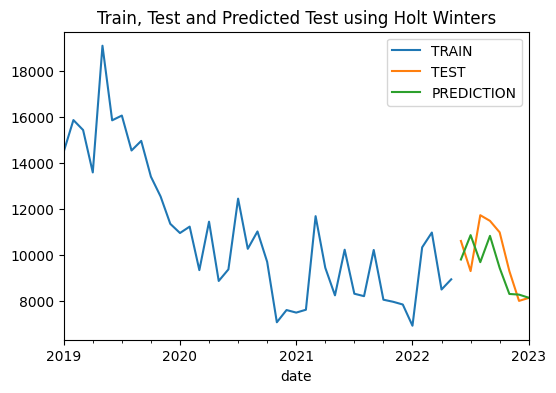

In [80]:
fitted_model4 = ExponentialSmoothing(train4['2.4 CAG sales'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions4 = fitted_model4.predict(start=test4.index[0], end=test4.index[-1])
# fitted_model4 = ExponentialSmoothing(train4['2.4 CAG sales'], trend='add', seasonal='add', seasonal_periods=12, damped=True)
# hw_model = fitted_model4.fit(optimized=True, remove_bias=False)
# pred = hw_model.predict(start=test4.index[0], end=test4.index[-1])
train4['2.4 CAG sales'].plot(legend=True,label='TRAIN')
test4['2.4 CAG sales'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions4.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

### Data from April 2020 - 2022

Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

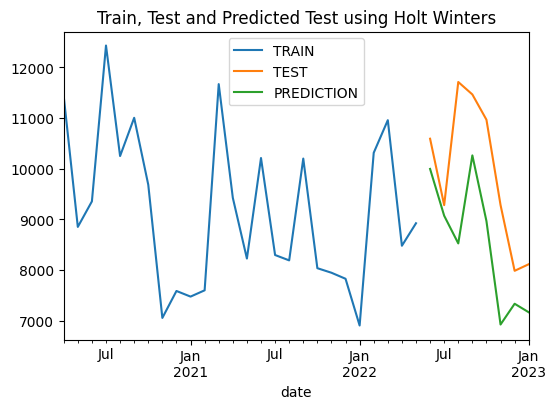

In [77]:
fitted_model4a = ExponentialSmoothing(train5['2.4 CAG sales'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions4a = fitted_model4a.predict(start=test4.index[0], end=test4.index[-1])
# fitted_model4 = ExponentialSmoothing(train4['2.4 CAG sales'], trend='add', seasonal='add', seasonal_periods=12, damped=True)
# hw_model = fitted_model4.fit(optimized=True, remove_bias=False)
# pred = hw_model.predict(start=test4.index[0], end=test4.index[-1])
train5['2.4 CAG sales'].plot(legend=True,label='TRAIN')
test4['2.4 CAG sales'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions4a.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [ ]:
#convert predictions to pandas dataframe
test_predictions4= pd.DataFrame(data=test_predictions4)
test_predictions4

In [78]:
#convert predictions to pandas dataframe
test_predictions4a= pd.DataFrame(data=test_predictions4a)
test_predictions4a

,0
2022-06-01,9994.748493
2022-07-01,9070.425371
2022-08-01,8523.993309
2022-09-01,10262.066533
2022-10-01,8964.328981
2022-11-01,6922.645280
2022-12-01,7332.691824
2023-01-01,7164.685991


In [ ]:
#convert predictions to pandas dataframe
pred = pd.DataFrame(data=pred)
pred

## Model Evaluation

In [ ]:
prediction_compared = pd.concat([pred,test_predictions4,test4],axis=1)
prediction_compared

In [ ]:
#visualization
test4['2.4 CAG sales'].plot(legend=True,label='TEST',figsize=(9,6))
test_predictions4.plot(legend=True,label='PREDICTION',title= 'Predicted Sales vs Actual Sales from Jun-22 to Dec-22');

In [82]:
# Evaluation Metric 
print(f'Mean Absolute Error, including BEFORE COVID = {mean_absolute_error(test4,test_predictions4)}')
print(f'Mean Squared Error , including BEFORE COVID = {mean_squared_error(test4,test_predictions4)}')

Mean Absolute Error, including BEFORE COVID = 986.8634760694127
Mean Squared Error , including BEFORE COVID = 1396107.6907297135


In [83]:
# Evaluation Metric 
print(f'Mean Absolute Error, including BEFORE COVID = {mean_absolute_error(test4,test_predictions4a)}')
print(f'Mean Squared Error , including BEFORE COVID = {mean_squared_error(test4,test_predictions4a)}')

Mean Absolute Error, including BEFORE COVID = 1394.4267771036205
Mean Squared Error , including BEFORE COVID = 2862367.4628753047


# **2023 Forecasting**

## 2.4 CAG SALES -  used data with 2019 data

In [39]:
m_range = pd.date_range("2023-02-01", periods=12, freq="MS")
m_range


DatetimeIndex(['2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [40]:
sales_2023 = pd.DataFrame(index=m_range,columns= ['predicted sales'])
sales_2023

,predicted sales
2023-02-01,NaN
2023-03-01,NaN
2023-04-01,NaN
2023-05-01,NaN
2023-06-01,NaN
2023-07-01,NaN
2023-08-01,NaN
2023-09-01,NaN
2023-10-01,NaN
2023-11-01,NaN


In [85]:
fitted_model4 = ExponentialSmoothing(train4['2.4 CAG sales'],trend='add',seasonal='add',seasonal_periods=12).fit() #Triple Smoothing
pred_2023 = fitted_model4.predict(start=sales_2023.index[0], end=sales_2023.index[-1])
pred_2023 = pd.DataFrame(data=pred_2023,columns=['predicted sales'])
pred_2023

c:\Users\670275809\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,predicted sales
2023-02-01,9401.534911
2023-03-01,10291.620323
2023-04-01,9578.793784
2023-05-01,9833.491956
2023-06-01,10289.610503
2023-07-01,11350.463172
2023-08-01,10174.103132
2023-09-01,11318.854488
2023-10-01,9922.951059
2023-11-01,8791.417277


## 2.4 CAG Sales Predictions - used data from 2020-2022

In [86]:
fitted_model5 = ExponentialSmoothing(train5['2.4 CAG sales'],trend='add', seasonal= 'add',seasonal_periods=12).fit() #Double Smoothing
pred_2023 = fitted_model5.predict(start=sales_2023.index[0], end=sales_2023.index[-1])
pred_2023 = pd.DataFrame(data=pred_2023,columns=['predicted sales'])
pred_2023

,predicted sales
2023-02-01,8099.401510
2023-03-01,11581.539426
2023-04-01,9565.303177
2023-05-01,8431.068087
2023-06-01,10070.383508
2023-07-01,9146.060386
2023-08-01,8599.628324
2023-09-01,10337.701549
2023-10-01,9039.963996
2023-11-01,6998.280296


## 50K CAG Sales Predictions

In [ ]:
fitted_model = ExponentialSmoothing(train1['total_sales'],trend='mul').fit()
pred_2023_50k = fitted_model.predict(start=sales_2023.index[0], end=sales_2023.index[-1])
pred_2023_50k= pd.DataFrame(data=pred_2023_50k,columns=['predicted sales'])
pred_2023_50k